In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
from scipy.io import loadmat

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.model_selection import train_test_split

In [4]:
!ls
%mkdir data
!ls

data  drive  entrenamiento.csv	prueva.csv  sample_data
mkdir: cannot create directory ‘data’: File exists
data  drive  entrenamiento.csv	prueva.csv  sample_data


In [5]:
data = pd.read_csv('/content/drive/MyDrive/IA/sign_mnist_train.csv')

# Division de dataset en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data.to_csv("entrenamiento.csv", index=False)
test_data.to_csv("prueva.csv", index=False)
data = pd.read_csv('/content/entrenamiento.csv')
data = data.to_numpy()
X, y= data [:, 1:],data[:, 0]
y[y == 24] = 0
input_layer_size  = 784
num_labels = 24
m = y.size
print(X.shape)
print(y.shape)

(21964, 784)
(21964,)


In [6]:
data.shape

(21964, 785)

In [7]:
# Ingresar imágenes de dígitos de 20x20
#input_layer_size  = 400

# 10 etiquetas, de 1 a 10 (tomar en cuenta que se asigna "0" a la etiqueta 10)
#num_labels = 10

#  datos de entrenamiento almacenados en los arreglos X, y
# data = loadmat(os.path.join('Dataset', 'ex3data1.mat'))
#data = loadmat('/content/drive/MyDrive/IA/sign_mnist_train.csv' )

#X, y = data['X'], data['y'].ravel()
# establecer el dígito cero en 0, en lugar del 10 asignado a este conjunto de datos
# Esto se hace debido a que el conjunto de datos se utilizó en MATLAB donde no hay índice 0
#y[y == 10] = 0

#m = y.size

In [8]:
# len(data['X'][0])
# print(data['y'][4000])
# print(data['X'][0])
# print(data['X'][0].shape)
# yy = data['X'][0].ravel()
# print(yy)
# print(yy.shape)

# print(X)
# print(y)
# print(m)

In [9]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

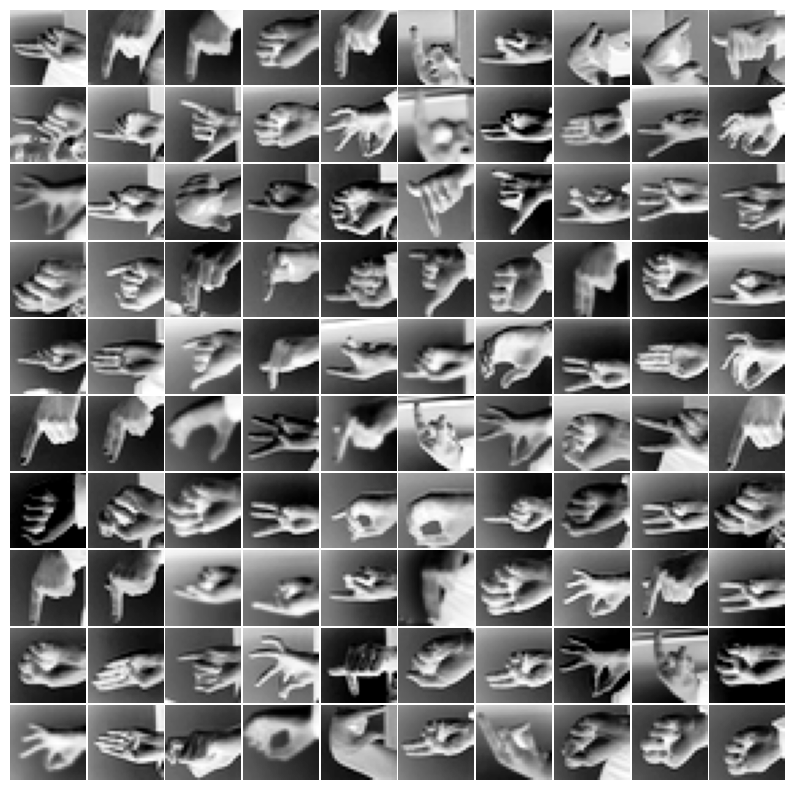

In [10]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

In [11]:
def sigmoid(z):
    """
    Calcula la sigmoide de z.
    """
    clip_z=np.clip(z,-700,700)
    return 1.0 / (1.0 + np.exp(-clip_z))

In [12]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Calcula el costo de usar theta como parámetro para la regresión logística regularizada y
    el gradiente del costo w.r.t. a los parámetros.

    Parametros
    ----------
    theta : array_like
        Parametro theta de la regresion logistica. Vector de la forma(shape) (n, ). n es el numero de caracteristicas
        incluida la intercepcion

    X : array_like
        Dataset con la forma(shape) (m x n). m es el numero de ejemplos, y n es el numero de
        caracteristicas (incluida la intercepcion).

    y : array_like
        El conjunto de etiquetas. Un vector con la forma (shape) (m, ). m es el numero de ejemplos

    lambda_ : float
        Parametro de regularización.

    Devuelve
    -------
    J : float
        El valor calculado para la funcion de costo regularizada.

    grad : array_like
        Un vector de la forma (shape) (n, ) que es el gradiente de la
        función de costo con respecto a theta, en los valores actuales de theta..
    """
    # Inicializa algunos valores utiles
    m = y.size

    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    temp = theta
    temp[0] = 0

    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    return J, grad

In [13]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.

    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of
        data points, and n is the number of features. Note that we
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X.

    y : array_like
        The data labels. A vector of shape (m, ).

    num_labels : int
        Number of possible labels.

    lambda_ : float
        The logistic regularization parameter.

    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    """
    # algunas variables utiles
    m, n = X.shape

    # print(m, n)
    all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)
        # print(res)
        all_theta[c] = res.x

    return all_theta

In [14]:
lambda_ = 0.001
all_theta = oneVsAll(X, y, num_labels, lambda_)

<ipython-input-12-179220550d1c>:46: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
<ipython-input-12-179220550d1c>:46: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
<ipython-input-12-179220550d1c>:46: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
<ipython-input-12-179220550d1c>:46: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
<ipython-input-12-179220550d1c>:46: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) *

In [15]:
print(all_theta.shape)
print(all_theta[0])

(24, 785)
[-6.91116649e-05  3.51016367e-03  3.65555298e-03  1.94393137e-03
  5.22393087e-04  1.01463602e-04  6.08104017e-04  4.38151373e-04
  3.82655162e-04  2.98566932e-04 -4.36212462e-04 -3.17166881e-04
  6.10002978e-05  1.09710699e-04 -6.21603648e-04 -9.11353228e-04
 -1.32410366e-03 -1.51093222e-03 -1.76286622e-03 -2.05116993e-03
 -2.40311489e-03 -2.45373357e-03 -2.83173285e-03 -3.65438289e-03
 -2.80073484e-03 -1.90833888e-03  8.07753980e-05  1.00633245e-03
  1.25330957e-03  3.42209006e-03  3.38245138e-03  1.68432822e-03
  3.61226485e-04  7.06277338e-05  3.67627773e-04  1.10535798e-04
 -6.78894177e-05 -2.38292322e-05 -1.63857433e-04 -4.51527674e-04
  5.89985615e-04  1.41573187e-03 -2.26511360e-04 -8.51948549e-04
 -7.74864054e-04 -1.17383287e-03 -1.14975005e-03 -1.45878902e-03
 -2.35926702e-03 -1.81456727e-03 -2.25353605e-03 -3.64192445e-03
 -3.21757826e-03 -8.34324276e-04  5.43024428e-04  7.35081650e-04
  9.56545835e-04  3.39817593e-03  3.04974459e-03  1.36326973e-03
  3.78562761e-0

In [16]:
def predictOneVsAll(all_theta, X):
    """
    Devuelve un vector de predicciones para cada ejemplo en la matriz X.
    Tenga en cuenta que X contiene los ejemplos en filas.
    all_theta es una matriz donde la i-ésima fila es un vector theta de regresión logística entrenada para la i-ésima clase.
    Debe establecer p en un vector de valores de 0..K-1 (por ejemplo, p = [0, 2, 0, 1]
    predice clases 0, 2, 0, 1 para 4 ejemplos).

    Parametros
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.

    X : array_like
        Data points to predict their labels. This is a matrix of shape
        (m x n) where m is number of data points to predict, and n is number
        of features without the bias term. Note we add the bias term for X in
        this function.

    Devuelve
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    """

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

(21964, 784)
Precision del conjuto de entrenamiento: 94.24%
(30, 784)
(30, 785)
[11 22  1 23 22 13 15  6  0 14 12  2  2  2 20 20  3  6  4 12 18  5 20  8
 21  0  2 16 18  2] [11 22  1 23 22 13 15  6  0 14 12  2  2  2 22 20  5  6  4 12 18 22  5  8
 21  0  2 16 18  2]


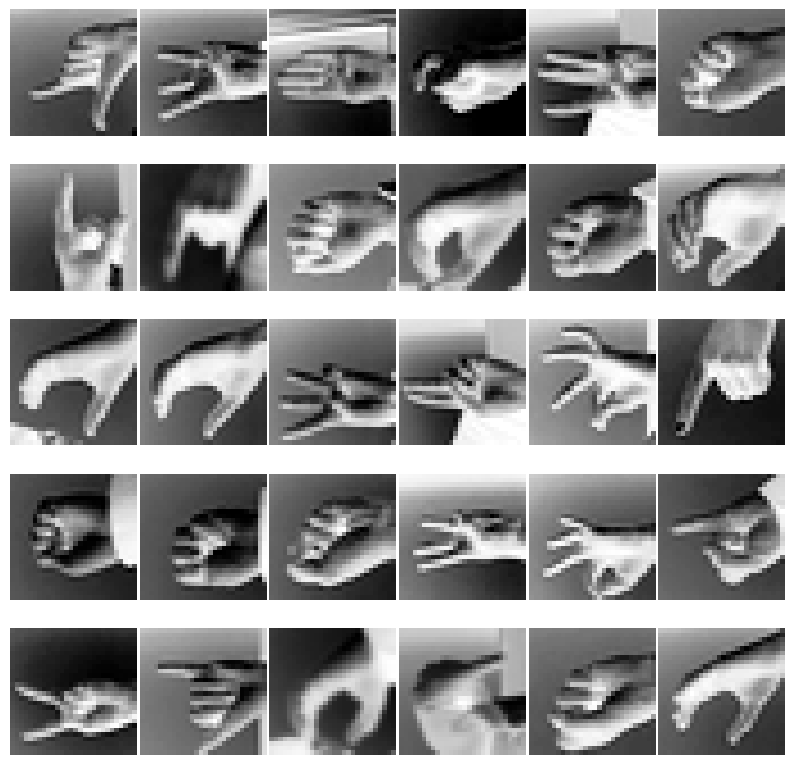

In [18]:

print(X.shape)
pred = predictOneVsAll(all_theta, X)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred == y) * 100))
# XPrueba = X[4490:4590, :].copy()

# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 30, replace=False)
XPrueba = X[rand_indices, :]
XPruebaV = XPrueba.copy()


print(XPrueba.shape)
#print(np.ones((1)))
#print(XPrueba)
#p = np.zeros(1)
XPrueba = np.concatenate([np.ones((30, 1)), XPrueba], axis=1)
print(XPrueba.shape)
p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis = 1)
print(p, y[rand_indices])

displayData(XPruebaV)